# Use Crocoddyl to run the trajectory

The idea of this page is to take the trajectory as an input (cost function) and see if crocoddyl can perform a feasable trajectory.

In [33]:
# Imports robot and initialize visualisation
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
import meshcat.geometry as mg
import numpy as np
import meshcat

# import robot_loader from scripts
from scripts.robot_loader import load_robot_paths

# load paths from scripts
urdf_path, mesh_path = load_robot_paths()

print("Launching MeshCat...")
viz = meshcat.Visualizer()
print("Adding a grid to represent the ground.")
viz["/Grid"].set_property("visible", True)

# Load robot into Pinocchio
print("Loading robot model into Pinocchio...")
try:
    model, collision_model, visual_model = pin.buildModelsFromUrdf(
        urdf_path,
        mesh_path,
    )
    print("Pinocchio model loaded successfully.")
except Exception as e:
    print(f"Error loading robot: {e}")

# Create Pinocchio visualizer
robot_visualizer = MeshcatVisualizer(model, collision_model, visual_model)
    
print("--- Loading complete. Objects are ready to be used. ---")

if model:
    viewer_window = viz.open()
    robot_visualizer.initViewer(viewer=viz)
    robot_visualizer.loadViewerModel()
    #robot_visualizer.displayFrames(True)
    print("\nEnvironment is ready !")

--- Searching for robot paths ---
Detected project root directory: /home/cpene/Documents/robot_playground
Asset paths verified.
Detected urdf file: /home/cpene/Documents/robot_playground/robot_models/biped_assets/biped_assets/models/h12/h12_12dof.urdf
Detected mesh directory: /home/cpene/Documents/robot_playground/robot_models/biped_assets/biped_assets/models/h12
Launching MeshCat...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/
Adding a grid to represent the ground.
Loading robot model into Pinocchio...
Pinocchio model loaded successfully.
--- Loading complete. Objects are ready to be used. ---

Environment is ready !


In [5]:
# Load trajectory (see launch_vizualization file for more details)
import time
import os

trajectory_file = os.path.join("data", "h1v2_squat_fixed_ankle_states.npy")
trajectory_data = np.load(trajectory_file)
trajectory_data = np.squeeze(trajectory_data)

pinocchio_order = [
    'left_hip_yaw_joint', 'left_hip_pitch_joint', 'left_hip_roll_joint', 
    'left_knee_joint', 'left_ankle_pitch_joint', 'left_ankle_roll_joint', 
    'right_hip_yaw_joint', 'right_hip_pitch_joint', 'right_hip_roll_joint', 
    'right_knee_joint', 'right_ankle_pitch_joint', 'right_ankle_roll_joint', 
    'torso_joint', 
    'left_shoulder_pitch_joint', 'left_shoulder_roll_joint', 'left_shoulder_yaw_joint', 
    'left_elbow_joint', 'left_wrist_roll_joint', 'left_wrist_pitch_joint', 'left_wrist_yaw_joint', 
    'right_shoulder_pitch_joint', 'right_shoulder_roll_joint', 'right_shoulder_yaw_joint', 
    'right_elbow_joint', 'right_wrist_roll_joint', 'right_wrist_pitch_joint', 'right_wrist_yaw_joint'
]

trajectory_file_order = [
    'left_hip_yaw_joint', 'right_hip_yaw_joint', 'torso_joint', 
    'left_hip_pitch_joint', 'right_hip_pitch_joint', 'left_shoulder_pitch_joint', 
    'right_shoulder_pitch_joint', 'left_hip_roll_joint', 'right_hip_roll_joint', 
    'left_shoulder_roll_joint', 'right_shoulder_roll_joint', 'left_knee_joint', 
    'right_knee_joint', 'left_shoulder_yaw_joint', 'right_shoulder_yaw_joint', 
    'left_ankle_pitch_joint', 'right_ankle_pitch_joint', 'left_elbow_joint', 
    'right_elbow_joint', 'left_ankle_roll_joint', 'right_ankle_roll_joint', 
    'left_wrist_roll_joint', 'right_wrist_roll_joint', 'left_wrist_pitch_joint', 
    'right_wrist_pitch_joint', 'left_wrist_yaw_joint', 'right_wrist_yaw_joint'
]

source_indices = [trajectory_file_order.index(joint_name) for joint_name in pinocchio_order]

In [34]:
# import converter tools from scripts
from scripts.conversion import build_pinocchio_state

# Conversion du premier point pour l'état initial x0
q0, v0 = build_pinocchio_state(trajectory_data[0], source_indices)
x0 = np.concatenate([q0, v0])
robot_visualizer.display(q0)

### **Crocoddyl**
Now, we will implement crocoddyl trajectory.
The aim is to go from configuration x(q, v) to commands u = tau_q

### Step 1: Defining the Robotic System

We need to define the space state **x = (q, v)** and how to perform correct mathematical operations on them (given by pinocchio model).

Then, we need to define the output **u**, that will correspond to the torques of the actuated joints. At this point we need to specify that the robot has a floating base. 



### Step 2: Creating the Action Sequence ("Running Models")

This is a loop that runs for each trajectory point from **t=0** to **t=N-1**, with the same time interval provided by the trajectory.

1. convert the trajectory data so it is suitable to be used with pinocchio
2. Create the DAM (Differential Action Model). it contains the dynamics and the costs functions.
3. Define the costs and associated weights :
    - on the state point given by the trajectory
    - on the command to minimize the effort 
4. Discretize the model -> Transforms the continuous differential model into a discrete-time action model that the solver can use.
5. Stores the discretized action model for this time interval.     



### Step 3: Creating the Terminal Model

This is for the last point (**t=N**). The steps are the same than for the others points but we change the costs and weights.

Costs :
    - on the state given by the trajectory with high weight



### Step 4: Assembling the Full Problem

Assembles all the pieces into a single optimal control problem.


In [31]:
# We want the frame associated to the feet. 
left_foot_frame_id = model.getFrameId('left_ankle_roll_link')
right_foot_frame_id = model.getFrameId('right_ankle_roll_link')

data = model.createData()

pin.forwardKinematics(model, data, q0)
pin.updateFramePlacements(model, data)

left_frame_pose = data.oMf[left_foot_frame_id]
sphere_geometry1 = mg.Sphere(0.04)
red_material = mg.MeshLambertMaterial(color=0xff0000)
viz[f"markers/{left_foot_frame_id}"].set_object(sphere_geometry1, red_material)
viz[f"markers/{left_foot_frame_id}"].set_transform(left_frame_pose.homogeneous)

right_frame_pose = data.oMf[right_foot_frame_id]
sphere_geometry2 = mg.Sphere(0.04)
red_material = mg.MeshLambertMaterial(color=0xff0000)
viz[f"markers/{right_foot_frame_id}"].set_object(sphere_geometry2, red_material)
viz[f"markers/{right_foot_frame_id}"].set_transform(right_frame_pose.homogeneous)


In [35]:
import crocoddyl

# --- STEP 1 : Defining the Robotic System --- 
state = crocoddyl.StateMultibody(model) # input x = (q, v)
actuation = crocoddyl.ActuationModelFloatingBase(state) # output u = tau_q (with floating base taking into account)

# We want the frame associated to the feet. 
left_foot_frame_id = model.getFrameId('left_ankle_roll_link')
right_foot_frame_id = model.getFrameId('right_ankle_roll_link')


# --- STEP 2 : Creating the Action Sequence ("Running Models") ---
running_models = [] # for each point on the trajectory
dt = 0.03333  # Pas de temps de la discrétisation, je garde le meme que celui de la trajectoire initiale

for i in range(len(trajectory_data) - 1):

    # Convert trajectory point to pinocchio format
    q_target, v_target = build_pinocchio_state(trajectory_data[i+1], source_indices)
    target_state = np.concatenate([q_target, v_target])

    # 1. Costs
    running_costs = crocoddyl.CostModelSum(state, actuation.nu)
    
    # on the state point given by the trajectory
    residual_state = crocoddyl.ResidualModelState(state, target_state, actuation.nu)
    state_cost = crocoddyl.CostModelResidual(state, residual_state)
    
    # on the command to minimize the effort
    residual_control = crocoddyl.ResidualModelControl(state, actuation.nu)
    control_cost = crocoddyl.CostModelResidual(state, residual_control)

    running_costs.addCost(name="state_cost", cost=state_cost, weight=1e-1)
    running_costs.addCost(name="control_cost", cost=control_cost, weight=1e-4)
    
    # Differential Action Model (DAM)
    # Create a container to store the dynamics and costs
    diff_model = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, running_costs)
    # DifferentialActionModelContactFwdDynamics use that for contacts

    # Create tthe Integrated Action Model (IAM) using EUler. Could use RKR instead
    running_models.append(crocoddyl.IntegratedActionModelEuler(diff_model, dt))
    

# --- STEP 3 : Creating the Action Sequence ("Terminal Model") ---
q_final, v_final = build_pinocchio_state(trajectory_data[-1], source_indices)
final_state = np.concatenate([q_final, v_final])

terminal_costs = crocoddyl.CostModelSum(state, actuation.nu)

residual_final_state = crocoddyl.ResidualModelState(state, final_state, actuation.nu)
terminal_state_cost = crocoddyl.CostModelResidual(state, residual_final_state)

terminal_costs.addCost(name="terminal_state_cost", cost=terminal_state_cost, weight=1e2)

diff_model = crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, terminal_costs)
terminal_model = crocoddyl.IntegratedActionModelEuler(diff_model, 0.)


# --- STEP 4 : Assembling the Full Problem (shooting problem) ---
q0_pin, v0_pin = build_pinocchio_state(trajectory_data[0], source_indices)
x0 = np.concatenate([q0_pin, v0_pin])
problem = crocoddyl.ShootingProblem(x0, running_models, terminal_model)

In [36]:
# Create FDDP solver
solver = crocoddyl.SolverFDDP(problem)

#solver.setCallbacks([
    #crocoddyl.CallbackLogger(),
    #crocoddyl.CallbackVerbose()
#])

# 3. Create an initial guess 
# we are looking at a problem with 176 states and 175 commands
# xs_init should be of size 176 -> we use the data on the trajectory as the first guess
# us_init should be of size 175 -> use 0 for all values
xs_init = []
for i in range(len(trajectory_data)):
    q_pin, v_pin = build_pinocchio_state(trajectory_data[i], source_indices)
    x = np.concatenate([q_pin, v_pin])
    xs_init.append(x)
print(f"xs_init dimension : {len(xs_init)}")

us_init = [np.zeros(actuation.nu) for model in problem.runningModels]
print(f"us_init dimension : {len(us_init)}")

# 4. Appeler solve() en spécifiant l'estimation initiale et le nombre d'itérations
MAX_ITER = 5000  # On donne un nombre d'itérations suffisant
converged = solver.solve(xs_init, us_init, MAX_ITER)


# 5. Analyser les résultats
if converged:
    print("SUCCESS: FDDP converged.")
else:
    print("FAILURE: FDDP did not converge.")

xs_init dimension : 176
us_init dimension : 175
SUCCESS: FDDP converged.


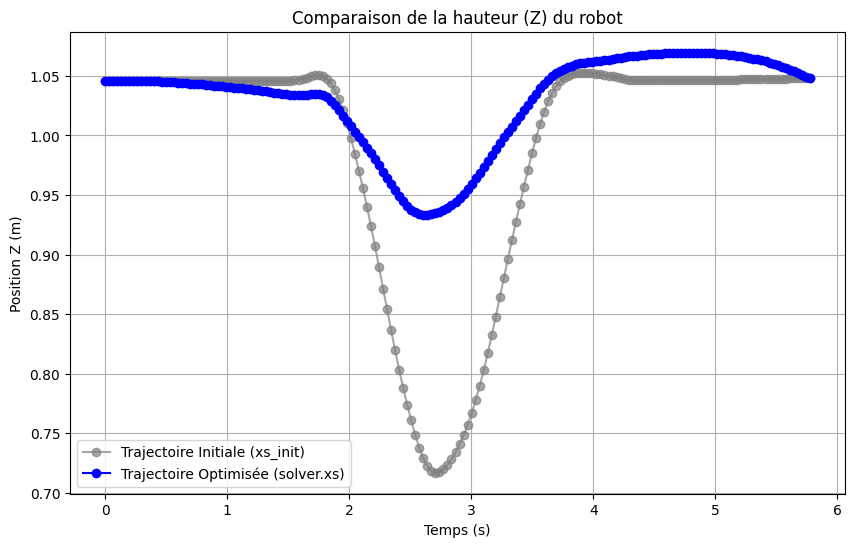

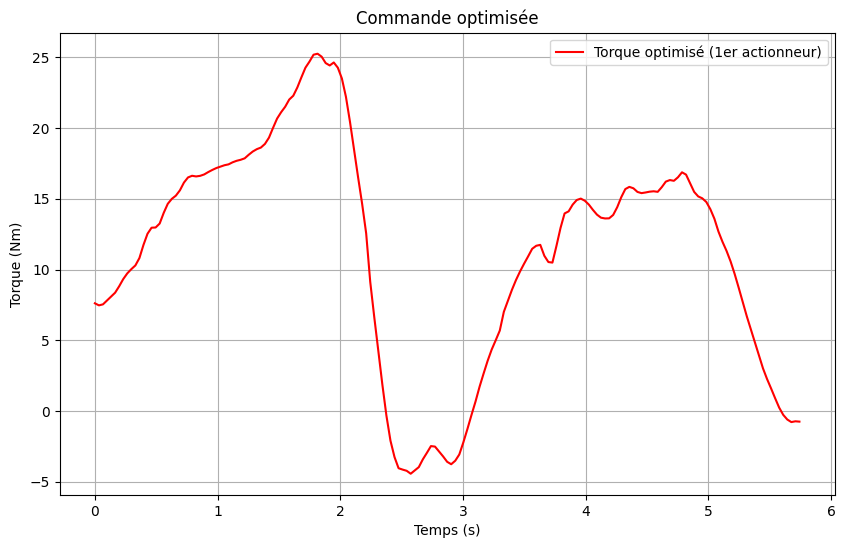

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Récupérer la solution depuis le solveur
xs_res = solver.xs
us_res = solver.us

# Extraire une coordonnée spécifique pour la visualisation
# L'index 2 correspond à la position en Z du 'floating base' dans Pinocchio (x,y,Z,qx,qy,qz,qw)
# Adaptez cet index si vous voulez voir autre chose (ex: un angle de joint)
z_initial = [x[2] for x in xs_init]
z_optimized = [x[2] for x in xs_res]

# Créer l'axe du temps pour le plot
time_axis = np.arange(len(xs_init)) * dt # dt est le pas de temps que vous avez défini

# Plotter les résultats
plt.figure(figsize=(10, 6))
plt.plot(time_axis, z_initial, 'o-', label="Trajectoire Initiale (xs_init)", color='gray', alpha=0.7)
plt.plot(time_axis, z_optimized, 'o-', label="Trajectoire Optimisée (solver.xs)", color='blue')
plt.title("Comparaison de la hauteur (Z) du robot")
plt.xlabel("Temps (s)")
plt.ylabel("Position Z (m)")
plt.legend()
plt.grid(True)
plt.show()

# Vous pouvez aussi plotter les commandes (torques)
# Exemple pour le premier torque
u0_optimized = [u[0] for u in us_res]
time_axis_u = np.arange(len(us_res)) * dt

plt.figure(figsize=(10, 6))
plt.plot(time_axis_u, u0_optimized, label="Torque optimisé (1er actionneur)", color='red')
plt.title("Commande optimisée")
plt.xlabel("Temps (s)")
plt.ylabel("Torque (Nm)")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Launch the simulation
print("Starting animation...")
dt = 0.033

xs_opt = solver.xs

for x in xs_opt:

    # We call the conversion tool
    q = x[:model.nq]

    # for Debug
    # print(f"g finale size: {q.shape[0]} (Expected: {model.nq})")

    # Send q to robot visualization
    robot_visualizer.display(q)

    # dt is 0.033333333 s
    time.sleep(dt)

print("\nAnimation end.")

Starting animation...

Animation end.
